In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from bs4 import BeautifulSoup
import re, unicodedata
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from dateutil import parser
from nltk.sentiment import SentimentIntensityAnalyzer   # VADER
import nltk, bs4, sklearn
import nltk; nltk.download('vader_lexicon')



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tomasmock/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [29]:
# 1. Point to file
file_path = '/Users/tomasmock/Downloads/Graduate Exercise FTI StratComms.xlsx'  

# 2. Read the Excel into a DataFrame
df = pd.read_excel(file_path)

In [30]:
# First few rows
df.head()

,source_name,title,body,pif_summary,pif_sentiment_reason,pif_sentiment,publication_datetime,source_code,word_count,region_of_origin,pif_risks,pif_opportunities
0,The Straits Times,Saudi firms sue ex-spymaster in Canada over 'm...,OTTAWA • Saudi state-owned companies have sued...,The article details a lawsuit by Saudi state-o...,The article presents serious allegations again...,Negative,2021-01-31T00:00:00Z,STIMES,381,ASIA SEASIAZ SINGP,[Association with alleged fraud undermines PIF...,[Opportunity to clarify PIF's commitment to et...
1,The Times of India,What is Saudi Arabia's Neom project: Key thing...,NEW DELHI: Top global oil exporter Saudi Arabi...,The article discusses Saudi Arabia's Neom proj...,"The article portrays PIF positively, emphasizi...",Positive,2021-01-12T00:00:00Z,TOI,412,ASIA INDIA SASIAZ,[PIF's reputation may suffer if Neom fails to ...,[PIF can enhance its global reputation by lead...
2,South China Morning Post,Happy ending needed as sale of HK story to wid...,"After years of turbulence, the city is keen to...",The article discusses Hong Kong's efforts to r...,"The article presents PIF in a neutral light, f...",Neutral,2022-10-22T00:00:00Z,SCMP,474,ASIA CHINA CHINAZ EASIA HKONG,[PIF's reputation may be affected by Hong Kong...,[PIF can enhance its global image through succ...
3,scmp.com,Happy ending needed as sale of Hong Kong story...,* Financial Secretary Paul Chan will put new i...,The article discusses Financial Secretary Paul...,The article presents a neutral sentiment towar...,Neutral,2022-10-22T00:00:00Z,SCMCOM,542,ASIA CHINA CHINAZ EASIA HKONG,[Association with political tensions in Hong K...,[PIF's participation could enhance its global ...
4,The Banker,Finance Minister of the Year 2022,"GLOBAL AND EUROPE Gintare Skaiste, Lithuania G...",The article highlights Saudi Arabia's Ministry...,The article portrays a favorable view of Saudi...,Positive,2022-01-01T00:00:00Z,BKNA,3778,EUR UK WEURZ,[Potential scrutiny over fiscal discipline in ...,[Enhanced global investment opportunities thro...


In [31]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1515 entries, 0 to 1514
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   source_name           1515 non-null   object
 1   title                 1515 non-null   object
 2   body                  1515 non-null   object
 3   pif_summary           1491 non-null   object
 4   pif_sentiment_reason  1491 non-null   object
 5   pif_sentiment         1515 non-null   object
 6   publication_datetime  1515 non-null   object
 7   source_code           1515 non-null   object
 8   word_count            1515 non-null   int64 
 9   region_of_origin      1515 non-null   object
 10  pif_risks             1515 non-null   object
 11  pif_opportunities     1515 non-null   object
dtypes: int64(1), object(11)
memory usage: 142.2+ KB


In [32]:
df.isna().sum()

source_name              0
title                    0
body                     0
pif_summary             24
pif_sentiment_reason    24
pif_sentiment            0
publication_datetime     0
source_code              0
word_count               0
region_of_origin         0
pif_risks                0
pif_opportunities        0
dtype: int64

In [ ]:

def clean_text(text, maxlen=1000):
    if not isinstance(text, str):
        return text
    # 1) Unicode‐normalize to NFKC (standardize accents/quotes/etc)
    text = unicodedata.normalize('NFKC', text)
    # 2) Replace common “strange” characters
    swaps = {
        '\u201c': '"',  # left double curly quote
        '\u201d': '"',  # right double curly quote
        '\u2018': "'",  # left single curly quote
        '\u2019': "'",  # right single curly quote
        '\u2013': '-',  # en-dash
        '\u2014': '-',  # em-dash
        '\u00A0': ' ',  # non-breaking space
    }
    for bad, good in swaps.items():
        text = text.replace(bad, good)
    # 3) Collapse any whitespace sequence into a single space
    text = re.sub(r'\s+', ' ', text).strip()
    # 4) Trim to ~1,000 chars
    return text[:maxlen]

# Apply to all relevant columns
cols_to_clean = [
    'body',
    'pif_risks',
    'pif_opportunities',
    'pif_summary',
    'pif_sentiment_reason'
]

for col in cols_to_clean:
    df[col] = df[col].apply(clean_text)

# Quick sanity check
df[cols_to_clean].head()


,body,pif_risks,pif_opportunities,pif_summary,pif_sentiment_reason
0,OTTAWA • Saudi state-owned companies have sued...,[Association with alleged fraud undermines PIF...,[Opportunity to clarify PIF's commitment to et...,The article details a lawsuit by Saudi state-o...,The article presents serious allegations again...
1,NEW DELHI: Top global oil exporter Saudi Arabi...,[PIF's reputation may suffer if Neom fails to ...,[PIF can enhance its global reputation by lead...,The article discusses Saudi Arabia's Neom proj...,"The article portrays PIF positively, emphasizi..."
2,"After years of turbulence, the city is keen to...",[PIF's reputation may be affected by Hong Kong...,[PIF can enhance its global image through succ...,The article discusses Hong Kong's efforts to r...,"The article presents PIF in a neutral light, f..."
3,* Financial Secretary Paul Chan will put new i...,[Association with political tensions in Hong K...,[PIF's participation could enhance its global ...,The article discusses Financial Secretary Paul...,The article presents a neutral sentiment towar...
4,"GLOBAL AND EUROPE Gintare Skaiste, Lithuania G...",[Potential scrutiny over fiscal discipline in ...,[Enhanced global investment opportunities thro...,The article highlights Saudi Arabia's Ministry...,The article portrays a favorable view of Saudi...


In [ ]:
# Parse into UTC-aware datetimes
df['publication_datetime'] = pd.to_datetime(
    df['publication_datetime'],
    utc=True,               # interpret the trailing 'Z' as UTC
    format='%Y-%m-%dT%H:%M:%SZ'  
)

#  Convert to Europe/London timezone
df['publication_datetime'] = df['publication_datetime'].dt.tz_convert('Europe/London')

# Verify
df['publication_datetime'].dtype, df['publication_datetime'].head()


(datetime64[ns, Europe/London],
 0   2021-01-31 00:00:00+00:00
 1   2021-01-12 00:00:00+00:00
 2   2022-10-22 01:00:00+01:00
 3   2022-10-22 01:00:00+01:00
 4   2022-01-01 00:00:00+00:00
 Name: publication_datetime, dtype: datetime64[ns, Europe/London])

In [ ]:

# 1. Define keywords/phrases
keywords = [
    'housing',
    'real estate',
    'real-estate',   # with a hyphen
    'property',
    'realty', 'residential', 'appartment', 'condo', 'condonium'
]

# 2. Build a case‐insensitive regex
pattern = r'(?i)\b(?:' + '|'.join(map(re.escape, keywords)) + r')\b'

# 3. Check each column, fill NaNs with empty strings to avoid errors
mask = (
    df['title'].fillna('').str.contains(pattern) |
    df['body'].fillna('').str.contains(pattern) |
    df['pif_summary'].fillna('').str.contains(pattern)
)

# 4. Assign to new column
df['real_estate'] = mask

# 5. Quick sanity check
df[['title', 'real_estate']].head(10)


,title,real_estate
0,Saudi firms sue ex-spymaster in Canada over 'm...,False
1,What is Saudi Arabia's Neom project: Key thing...,False
2,Happy ending needed as sale of HK story to wid...,False
3,Happy ending needed as sale of Hong Kong story...,False
4,Finance Minister of the Year 2022,False
5,ALI H KHALIL Q&A,False
6,Ukraine faces an unhappy ending even if it win...,False
7,Hong Kong's John Lee says he met oil giant Sau...,False
8,INVESTMENT BANK OF THE YEAR WINNER: CITI INVES...,False
9,THE BANKER INVESTMENT BANKING AWARDS 2024,False


In [37]:
# Counts of True vs False
counts = df['real_estate'].value_counts(dropna=False)
print(counts)


real_estate
False    1062
True      453
Name: count, dtype: int64


In [ ]:
# 1. Define PIF keywords/phrases
pif_keywords = [
    'PIF',
    'Public Investment Fund',
    'Saudi PIF',
    'Saudi Arabia sovereign wealth fund'
    
]

# 2. Build a case‐insensitive regex
pif_pattern = r'(?i)\b(?:' + '|'.join(map(re.escape, pif_keywords)) + r')\b'

# 3. Check each column (fill NaNs to avoid errors)
pif_mask = (
    df['title'].fillna('').str.contains(pif_pattern) |
    df['body'].fillna('').str.contains(pif_pattern) |
    df['pif_summary'].fillna('').str.contains(pif_pattern) |
    df['pif_sentiment_reason'].fillna('').str.contains(pif_pattern)
)

# 4. Assign the boolean column
df['PIF'] = pif_mask

# 5. See a quick count
print(df['PIF'].value_counts())


PIF
True     1486
False      29
Name: count, dtype: int64


In [ ]:
# Instantiate VADER
sia = SentimentIntensityAnalyzer()

# Helper to get compound score (or NaN if missing/empty)
def get_compound(text):
    if not isinstance(text, str) or text.strip() == '':
        return np.nan
    return sia.polarity_scores(text)['compound']

# Prepare empty columns
df['body_sentiment']    = np.nan
df['summary_sentiment'] = np.nan
df['reason_sentiment']  = np.nan
df['sentiment_score']   = np.nan

# Mask of rows to process
mask = df['PIF'] & df['real_estate']

# Apply only on masked rows
df.loc[mask, 'body_sentiment']    = df.loc[mask, 'body'].apply(get_compound)
df.loc[mask, 'summary_sentiment'] = df.loc[mask, 'pif_summary'].apply(get_compound)
df.loc[mask, 'reason_sentiment']  = df.loc[mask, 'pif_sentiment_reason'].apply(get_compound)

# Average compound scores into a single sentiment_score
df.loc[mask, 'sentiment_score'] = df.loc[mask, 
    ['body_sentiment','summary_sentiment','reason_sentiment']
].mean(axis=1)

# Verify
df.loc[mask, ['PIF','real_estate','sentiment_score']].head()


,PIF,real_estate,sentiment_score
18,True,True,0.512967
21,True,True,0.396433
28,True,True,0.890000
30,True,True,0.514267
36,True,True,0.879500


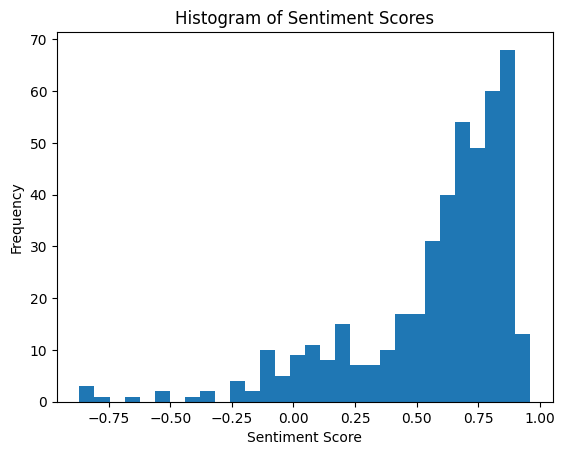

Mean sentiment_score:   0.574
Median sentiment_score: 0.691


In [42]:

# 1. Grab all non-NaN sentiment scores
scores = df['sentiment_score'].dropna()

# 2. Plot histogram
plt.hist(scores, bins=30)
plt.title('Histogram of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# 3. Compute mean and median
mean_score   = scores.mean()
median_score = scores.median()

print(f'Mean sentiment_score:   {mean_score:.3f}')
print(f'Median sentiment_score: {median_score:.3f}')


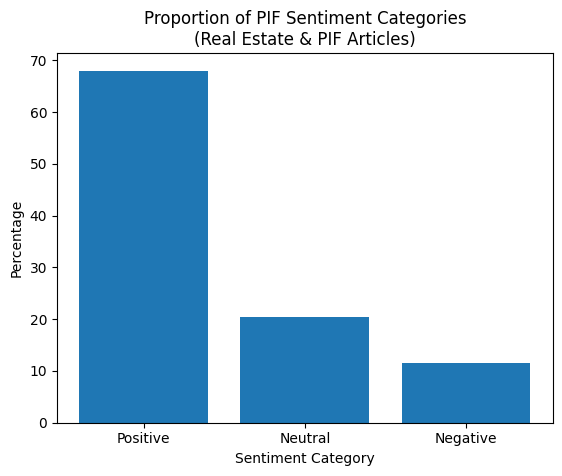

In [ ]:
# Filter for articles about both PIF and real estate
mask = df['PIF'] & df['real_estate']

# Calculate proportions
props = df.loc[mask, 'pif_sentiment'].value_counts(normalize=True) * 100

# Plot bar chart
plt.figure()
plt.bar(props.index, props.values)
plt.title('Proportion of PIF Sentiment Categories\n(Real Estate & PIF Articles)')
plt.xlabel('Sentiment Category')
plt.ylabel('Percentage')
plt.show()


In [44]:
# 1. Mask for articles about both PIF and real estate
mask = df['PIF'] & df['real_estate']

# 2. Compute proportions of each category in pif_sentiment
prop = df.loc[mask, 'pif_sentiment'] \
         .value_counts(normalize=True, dropna=False)  # normalize → proportion

# 3. (Optional) Convert to percentages
prop_pct = prop * 100

print("Proportion of each sentiment:")
print(prop)

print("\nPercentage of each sentiment:")
print(prop_pct.round(2))


Proportion of each sentiment:
pif_sentiment
Positive    0.680089
Neutral     0.203579
Negative    0.116331
Name: proportion, dtype: float64

Percentage of each sentiment:
pif_sentiment
Positive    68.01
Neutral     20.36
Negative    11.63
Name: proportion, dtype: float64


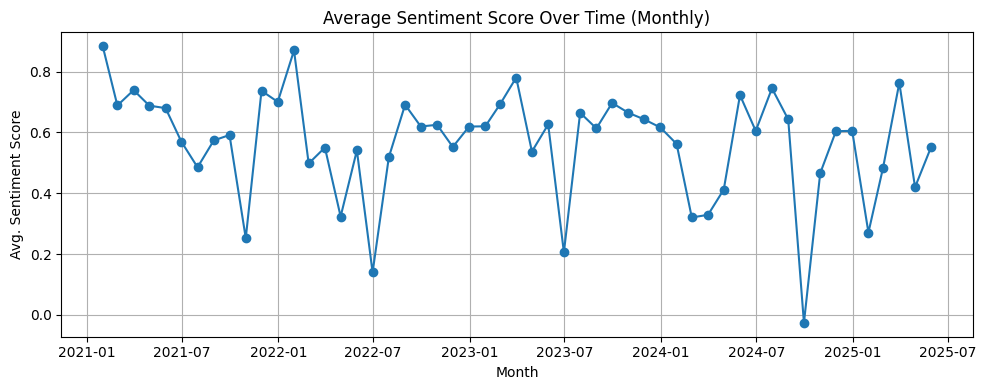

In [ ]:
# 1. Restrict to rows scored
mask = df['PIF'] & df['real_estate']

# 2. Ensure datetime index 
df_masked = df.loc[mask].copy()
df_masked.set_index('publication_datetime', inplace=True)

# 3. Resample by month and take the mean sentiment_score
monthly = df_masked['sentiment_score'].resample('M').mean()

# 4. Plot
plt.figure(figsize=(10, 4))
plt.plot(monthly.index, monthly.values, marker='o', linestyle='-')
plt.title('Average Sentiment Score Over Time (Monthly)')
plt.xlabel('Month')
plt.ylabel('Avg. Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 1. Filter to PIF & real estate
mask = df['PIF'] & df['real_estate']
df_topics = df.loc[mask].copy()

# 2. Combine text fields
df_topics['combined_text'] = (
    df_topics['body'].fillna('') + ' '
  + df_topics['pif_summary'].fillna('') + ' '
  + df_topics['pif_sentiment_reason'].fillna('')
)

# 3. TF-IDF vectorization
tfidf = TfidfVectorizer(
    max_df=0.95,      # ignore super-common terms
    min_df=2,         # ignore super-rare terms
    ngram_range=(2,3),
    stop_words='english'
)
tfidf_matrix = tfidf.fit_transform(df_topics['combined_text'])

# 4. Fit NMF with 8 topics
nmf = NMF(n_components=8, random_state=42)
W = nmf.fit_transform(tfidf_matrix)      # document-topic matrix (n_docs × 8)
H = nmf.components_                     # topic-term matrix (8 × n_terms)

# 5. Get top keywords per topic
feature_names = tfidf.get_feature_names_out()
n_top = 10
topic_keywords = []
for topic_idx, topic_weights in enumerate(H):
    top_idxs = topic_weights.argsort()[-n_top:][::-1]
    kws = [feature_names[i] for i in top_idxs]
    topic_keywords.append(kws)

# 6. Assign each article its dominant topic
df_topics['topic'] = W.argmax(axis=1)

# 7. Compute avg. sentiment per topic
topic_sentiment = df_topics.groupby('topic')['sentiment_score'].mean()

# Display results
for i, kws in enumerate(topic_keywords):
    print(f"Topic {i:>2}  |  AvgSentiment = {topic_sentiment.loc[i]: .3f}")
    print("   ", ", ".join(kws))
    print()


/Users/tomasmock/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Topic  0  |  AvgSentiment =  0.541
    crown prince, prince mohammed, bin salman, mohammed bin salman, mohammed bin, prince mohammed bin, crown prince mohammed, vision 2030, saudi arabia, bin abdulaziz

Topic  1  |  AvgSentiment =  0.740
    roshn group, estate developer, real estate developer, pif owned, real estate, giga project, vision 2030, riyadh roshn, highlights roshn, roshn group saudi

Topic  2  |  AvgSentiment =  0.745
    estate refinance, real estate refinance, saudi real estate, saudi real, real estate, refinance company, estate refinance company, company src, refinance company src, housing market

Topic  3  |  AvgSentiment = -0.056
    profit participation, equity like, bloomberg news, insolvency proceedings, 287 million, insolvency process, signa prime, real estate unit, austria pif, estate unit

Topic  4  |  AvgSentiment =  0.491
    saudi arabia, real estate, investment fund, public investment, public investment fund, arabia public investment, arabia public, economic c

In [ ]:
for col in ['pif_risks','pif_opportunities']:
    df[col] = df[col].apply(clean_text)   


In [51]:


def top_tfidf_terms(series, n_top=20, ngram_range=(2,3)):
    """
    Returns the top n_top terms by average TF-IDF score for the given text series.
    """
    vec = TfidfVectorizer(
        ngram_range=ngram_range,
        min_df=2,       # ignore extremely rare
        max_df=0.95,    # ignore extremely common
        stop_words='english'
    )
    X = vec.fit_transform(series.dropna())
    # Average TF-IDF across all docs
    mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
    terms = vec.get_feature_names_out()
    top_idx = mean_tfidf.argsort()[-n_top:][::-1]
    return pd.DataFrame({
        'term': terms[top_idx],
        'avg_tfidf': mean_tfidf[top_idx]
    })

# Top 20 risk-driving phrases
risk_keywords = top_tfidf_terms(df['pif_risks'], n_top=20)
print("Top Risk Drivers:")
print(risk_keywords)

# Top 20 opportunity-driving phrases
opp_keywords = top_tfidf_terms(df['pif_opportunities'], n_top=20)
print("\nTop Opportunity Drivers:")
print(opp_keywords)


Top Risk Drivers:
                          term  avg_tfidf
0           potential backlash   0.026542
1               pif reputation   0.021911
2            public perception   0.018027
3                 scrutiny pif   0.017209
4         negative perceptions   0.016083
5          negative perception   0.015980
6                     harm pif   0.015529
7               pif investment   0.015354
8                 saudi arabia   0.015302
9              negative public   0.015255
10             pif investments   0.015198
11              perception pif   0.015173
12                  poorly pif   0.014221
13              reflect poorly   0.014028
14          reflect poorly pif   0.013746
15  negative public perception   0.013643
16         reputational damage   0.013590
17                human rights   0.013264
18          increased scrutiny   0.012203
19         harm pif reputation   0.012140

Top Opportunity Drivers:
                        term  avg_tfidf
0               saudi arabia   0.0

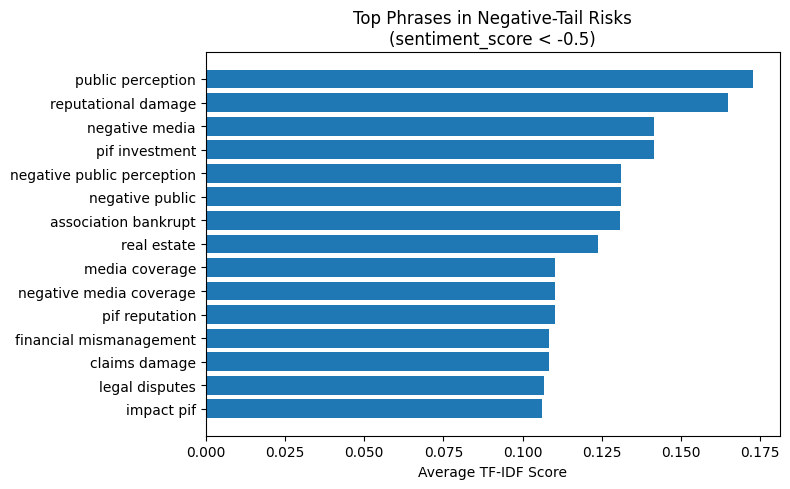

In [59]:
# 1. Filter to PIF & real_estate articles with strong negative sentiment
mask = (df['PIF'] & df['real_estate'] & (df['sentiment_score'] < -0.5))
df_neg = df.loc[mask]

# 2. Combine the two fields of interest
texts = (
    df_neg['pif_risks'].fillna('')
    
)

# 3. TF-IDF vectorization (1–3 grams)
vectorizer = TfidfVectorizer(
    ngram_range=(2,3),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)
X = vectorizer.fit_transform(texts)

# 4. Compute average TF-IDF score for each term
mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
terms = vectorizer.get_feature_names_out()

# 5. Grab the top 15 terms
top_n = 15
top_idx = mean_tfidf.argsort()[-top_n:][::-1]
top_terms  = terms[top_idx]
top_scores = mean_tfidf[top_idx]

# 6. Plot horizontal bar chart
plt.figure(figsize=(8, 5))
plt.barh(top_terms[::-1], top_scores[::-1])
plt.xlabel('Average TF-IDF Score')
plt.title('Top Phrases in Negative-Tail Risks\n(sentiment_score < -0.5)')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

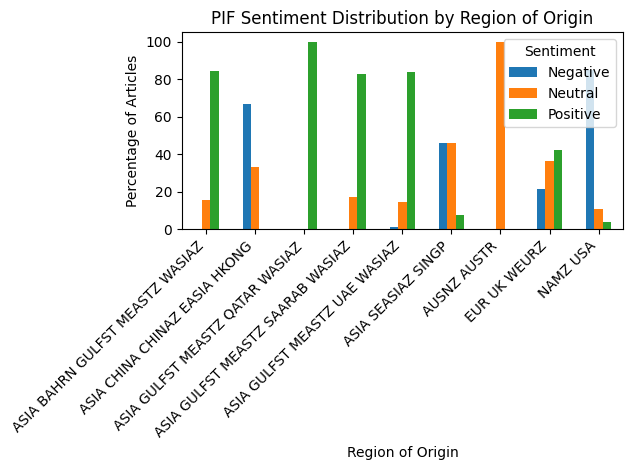

In [60]:
# 1. Filter to articles about both PIF and real estate (if desired)
mask = df['PIF'] & df['real_estate']
df_masked = df.loc[mask].copy()

# 2. Compute counts by region and sentiment
counts = (
    df_masked
    .groupby(['region_of_origin', 'pif_sentiment'])
    .size()
    .unstack(fill_value=0)
)

# 3. Convert to percentages within each region
props = counts.div(counts.sum(axis=1), axis=0) * 100

# 4. Plot comparative bar chart
plt.figure(figsize=(12, 6))
props.plot(kind='bar')
plt.title('PIF Sentiment Distribution by Region of Origin')
plt.xlabel('Region of Origin')
plt.ylabel('Percentage of Articles')
plt.legend(title='Sentiment', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Summary #

Overall, the mean sentiment score stands at 0.574 with a median of 0.691, revealing a generally positive media tone toward PIF in real estate. The distribution is left-skewed with long negative tails—few but notable negative instances—as the median exceeds the mean. Among these articles, 68% are positive, 20% neutral, and 11% negative. Over time, sentiment dips appear in July 2022, July 2023, and the second half of 2024, suggesting negative sentiment are sporadic but can be severe.

Topic modeling identified high-sentiment themes around sustainable tourism and development—keywords like “Red Sea development,” “sustainable tourism,” “Saudi real estate refinance,” and “housing market.” Low-sentiment topics feature financial or legal stress: “profit participation,” “insolvency proceedings,” “real estate unit,” and “Austria PIF.”

Risk-oriented language centers on reputation concerns: “potential backlash,” “public perception,” “scrutiny,” “harm PIF,” “reputational damage,” and “human rights.” Opportunity language emphasizes growth and vision: “Vision 2030,” “economic diversification,” “showcase commitment,” and “PIF leverage.”

In the most negative tail (sentiment score < –0.5), phrases like “loose investor confidence,” “negative public perception,” “financial mismanagement,” “claims damage,” and “legal dispute” dominate, signaling acute reputation challenges as the primary drivers of risk.

Most of the sharply negative coverage comes out of North America (NAMZ USA) and Greater China (ASIA CHINA/CHINAZ and EASIA HKONG), suggesting Western and Mainland/Hong Kong outlets probe PIF’s risks more critically. In contrast, outlets based in Qatar, the UAE and Saudi Arabia skew strongly positive—reflecting closer political and economic alignment, and perhaps a greater focus on PIF’s growth-and-development narrative in Gulf-region media.


## note ##

Please note that due to my computational constraints (still using 7 year old MacBook Pro), I was unable to deploy small language models from the Hugging Face library. Those models, thanks to their advanced context-modeling capabilities would enable me more accurate and deeper text analyses, and would be preferred for a more robust sentiment and topic exploration.